## Load data

In [520]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [521]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
algo = "reverse_hybrid"
# algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [522]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

merged_df.shape

(1062, 30)

In [523]:
# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

In [524]:
merged_df = merged_df[~merged_df['communityId'].isna()]
merged_df.shape

(1062, 32)

In [525]:
merged_df.isna().sum()

patientId                     0
sampleId                      0
CLL_EPITYPE                   0
DISEASE_TYPE                  0
IGLV3_21_R110                26
MUTATION_COUNT               88
TMB_NONSYNONYMOUS            88
TUMOR_MOLECULAR_SUBTYPE     145
U1_STATUS                   199
AGE                          50
AGE_SAMPLING                  0
COHORT                        0
DEATH_DAYS                    0
EXPRESSION_CLUSTER            0
FFS_MONTHS                    0
FFS_STATUS                    0
IGHV_IDENTITY_PERCENTAGE     18
IGHV_MUTATION_STATUS         15
OS_MONTHS                     0
OS_STATUS                     0
PRIOR_TREATMENT_CATEGORY      0
SEX                           0
TREATMENT_AFTER_SAMPLING    613
TREATMENT_STATUS              0
originId                      0
year                          0
originType                    0
originIdentifier              0
nodeId                        0
communityId                   0
FFS_STATUS_EVENT              0
OS_STATU

In [526]:
merged_df['TUMOR_MOLECULAR_SUBTYPE'] = merged_df['TUMOR_MOLECULAR_SUBTYPE'].fillna('unknown')
merged_df['CLL_EPITYPE'] = merged_df['CLL_EPITYPE'].replace('unclassified', 'unknown')
merged_df['IGHV_MUTATION_STATUS'] = merged_df['IGHV_MUTATION_STATUS'].fillna('unknown')

In [527]:
mutation_df.isna().sum()    

chr                   0
endPosition           0
entrezGeneId          0
keyword             396
mutationType          0
normalAltCount     1251
normalRefCount     1251
patientId             0
proteinChange         0
proteinPosEnd         0
proteinPosStart       0
referenceAllele       0
startPosition         0
tumorAltCount         0
tumorRefCount         0
variantAllele         0
variantType           0
hugoGeneSymbol        0
type                  0
dtype: int64

## Clinical Analysis

In [528]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# plot_community_sizes(community_df)

In [529]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
# print_overlapping_nodes(community_df)

In [530]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.violinplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

In [531]:
# demographic_summary(merged_df)

In [532]:
import plotly.express as px
import plotly.graph_objects as go


def compare_age_mutation_count(merged_df, comm1, comm2):

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([comm1, comm2])], y='AGE_SAMPLING', x='communityId', box=True, points='all',
                        title='Violin Plot of AGE_SAMPLING by Community')
    fig_violin.show()

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([0,1,2,3])], y='MUTATION_COUNT', x='communityId', box=True, points='all',
                        title='Violin Plot of MUTATION_COUNT by Community')
    fig_violin.show()

    # 2. KDE plot for AGE_SAMPLING for communities 1 and 2
    from scipy.stats import gaussian_kde

    # Filter data for communities 1 and 2
    df_1 = merged_df[merged_df['communityId'] == comm1]['AGE_SAMPLING']
    df_2 = merged_df[merged_df['communityId'] == comm2]['AGE_SAMPLING']

    # Generate KDEs
    kde_1 = gaussian_kde(df_1)
    kde_2 = gaussian_kde(df_2)

    x_vals = np.linspace(merged_df['AGE_SAMPLING'].min(), merged_df['AGE_SAMPLING'].max(), 200)
    y_1 = kde_1(x_vals)
    y_2 = kde_2(x_vals)

    # Create KDE plot
    fig_kde = go.Figure()
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_1, mode='lines', name=f'Community {comm1}'))
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_2, mode='lines', name=f'Community {comm2}'))
    fig_kde.update_layout(title=f'KDE Plot of AGE_SAMPLING for Communities {comm1} and {comm2}',
                        xaxis_title='AGE_SAMPLING',
                        yaxis_title='Density')
    fig_kde.show()

In [533]:
# compare_age_mutation_count(merged_df, 0, 1)

In [534]:
# compare_age_mutation_count(merged_df, 1, 2)

In [535]:
# compare_age_mutation_count(merged_df, 2, 3)

In [536]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated   unknown  unmutated
communityId                                        
0                     0.314103  0.006410   0.679487
1                     0.240000  0.020000   0.740000
2                     0.412500  0.025000   0.562500
3                     0.586207  0.000000   0.413793
4                     0.432432  0.000000   0.567568
5                     0.393162  0.025641   0.581197
6                     0.500000  0.000000   0.500000
7                     0.327273  0.027273   0.645455
8                     0.839827  0.012987   0.147186
9                     0.614865  0.013514   0.371622


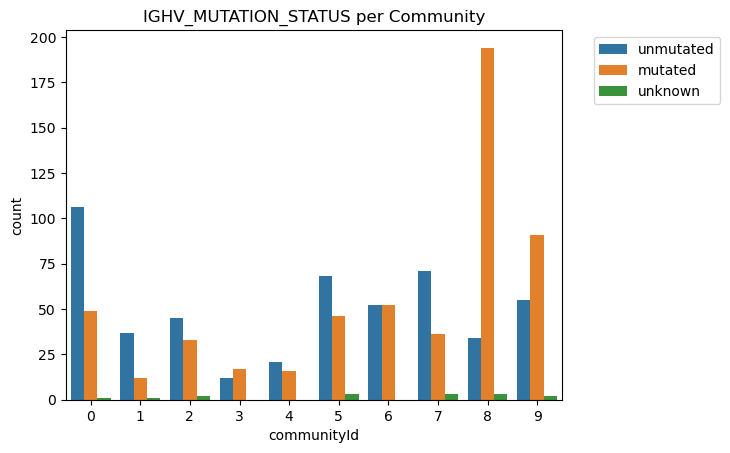


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL   unknown
communityId                                        
0            0.121795  0.198718  0.589744  0.089744
1            0.100000  0.160000  0.600000  0.140000
2            0.062500  0.312500  0.550000  0.075000
3            0.103448  0.379310  0.344828  0.172414
4            0.108108  0.189189  0.243243  0.459459
5            0.170940  0.196581  0.555556  0.076923
6            0.153846  0.288462  0.307692  0.250000
7            0.136364  0.218182  0.518182  0.127273
8            0.173160  0.601732  0.099567  0.125541
9            0.128378  0.405405  0.283784  0.182432


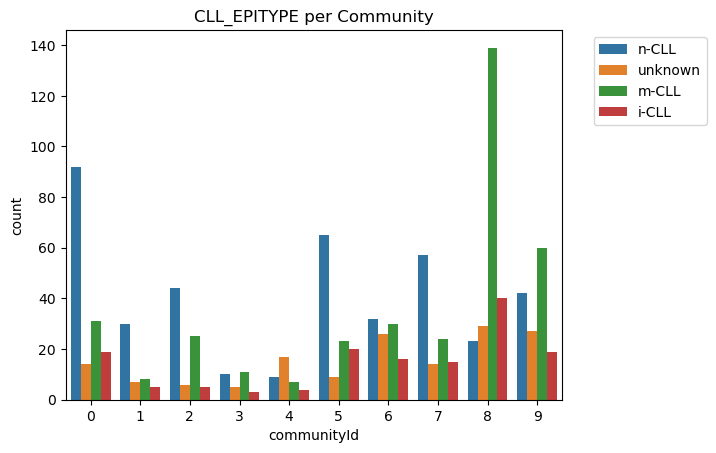


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL   unknown
communityId                                          
0                        0.384615  0.487179  0.128205
1                        0.440000  0.340000  0.220000
2                        0.475000  0.475000  0.050000
3                        0.620690  0.241379  0.137931
4                        0.675676  0.297297  0.027027
5                        0.487179  0.401709  0.111111
6                        0.528846  0.355769  0.115385
7                        0.463636  0.436364  0.100000
8                        0.476190  0.333333  0.190476
9                        0.412162  0.418919  0.168919


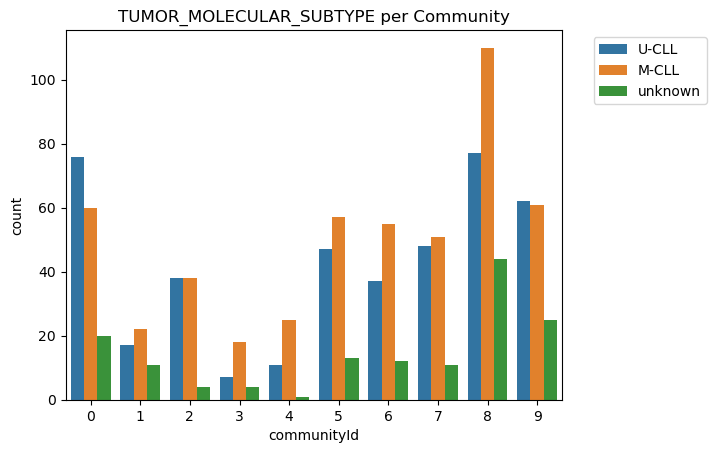


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.000000    0.076923       0.051282  0.000000   
1                              0.020000    0.000000       0.020000  0.000000   
2                              0.000000    0.037500       0.025000  0.000000   
3                              0.000000    0.000000       0.034483  0.000000   
4                              0.000000    0.000000       0.027027  0.000000   
5                              0.000000    0.025641       0.008547  0.000000   
6                              0.000000    0.000000       0.019231  0.000000   
7                              0.009091    0.081818       0.027273  0.009091   
8                              0.000000    0.012987       0.012987  0.000000   
9                              0.006757    0.047297       0.033

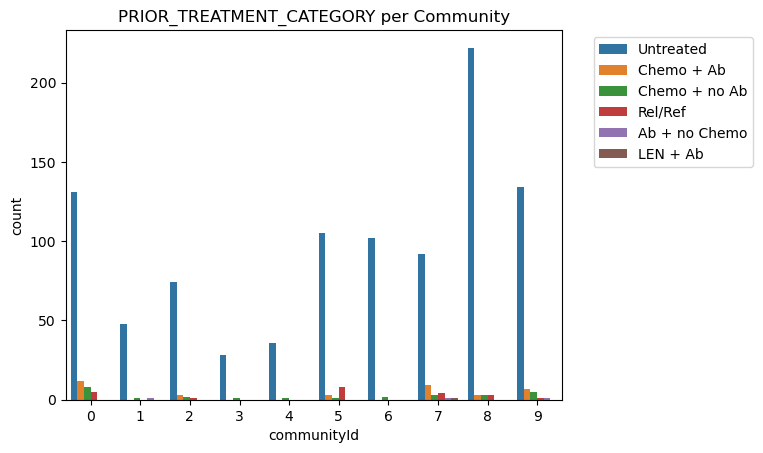


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.096774       0.00        0.00      0.016129   
1                              0.083333       0.00        0.00      0.000000   
2                              0.000000       0.00        0.00      0.000000   
3                              0.000000       0.00        0.00      0.000000   
4                              0.055556       0.00        0.00      0.000000   
5                              0.020000       0.02        0.02      0.000000   
6                              0.022727       0.00        0.00      0.000000   
7                              0.104167       0.00        0.00      0.020833   
8                              0.060606       0.00        0.00      0.000000   
9                              0.064516       0.00        0.00 

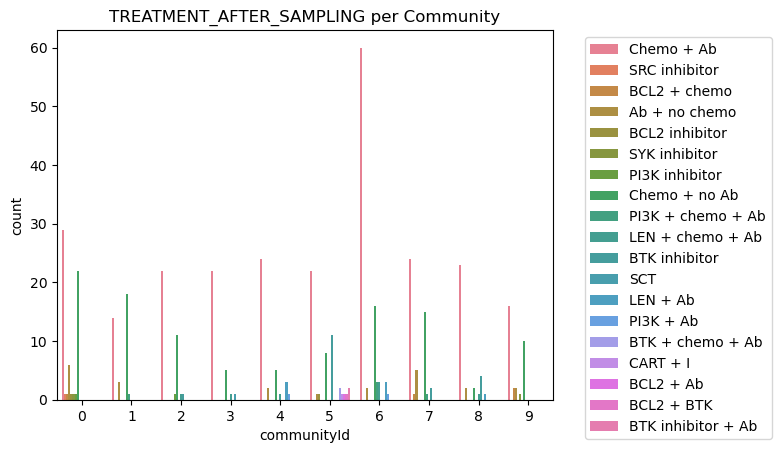

In [537]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)

In [538]:
def get_treatment_stats_by_community(df, community_id):
    # Filter the dataframe for the given community
    community_df = df[df['communityId'] == community_id]

    # Total number of patients in the community
    total_patients = len(community_df)

    # Group by TREATMENT_AFTER_SAMPLING and count occurrences including NaN
    treatment_counts = community_df['TREATMENT_AFTER_SAMPLING'].value_counts(dropna=False)

    # Create a list of dictionaries with treatment, count, and percentage
    treatment_stats = []
    for treatment, count in treatment_counts.items():
        treatment_stats.append({
            'TREATMENT_AFTER_SAMPLING': treatment,
            'Count': count,
            'Percentage': round((count / total_patients) * 100, 2) if total_patients > 0 else 0.0
        })

    # Sort the list by percentage of patients in descending order
    treatment_stats_sorted = sorted(treatment_stats, key=lambda x: x['Percentage'], reverse=True)

    return treatment_stats_sorted

In [539]:
treatment_data = {}
for i in range(len(merged_df['communityId'].unique())):
    treatment_data[i] = get_treatment_stats_by_community(merged_df, i)
display(treatment_data)

{0: [{'TREATMENT_AFTER_SAMPLING': nan, 'Count': 94, 'Percentage': 60.26},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab', 'Count': 29, 'Percentage': 18.59},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Count': 22,
   'Percentage': 14.1},
  {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
   'Count': 6,
   'Percentage': 3.85},
  {'TREATMENT_AFTER_SAMPLING': 'SRC inhibitor',
   'Count': 1,
   'Percentage': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo', 'Count': 1, 'Percentage': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 inhibitor',
   'Count': 1,
   'Percentage': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
   'Count': 1,
   'Percentage': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'PI3K inhibitor',
   'Count': 1,
   'Percentage': 0.64}],
 1: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Count': 18,
   'Percentage': 36.0},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab', 'Count': 14, 'Percentage': 28.0},
  {'TREATMENT_AFTER_SAMPLING': nan, 'Count': 14, 'Percentage': 28.0},


In [540]:
# Function to compare two communities
def compare_two_communities_for_treatment(data, id1, id2):
    set1 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id1]}
    set2 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common treatments between community {id1} and {id2}:", common)
    print(f"Unique to community {id1}:", unique_to_id1)
    print(f"Unique to community {id2}:", unique_to_id2)
    return common, unique_to_id1, unique_to_id2

In [541]:
# common_0_1, unique_0, unique_1 = compare_two_communities_for_treatment(treatment_data, 0, 1)

In [542]:
# common_1_2, unique_1, unique_2 = compare_two_communities_for_treatment(treatment_data, 1, 2)

In [543]:
# common_2_3, unique_2, unique_3 = compare_two_communities_for_treatment(treatment_data, 2, 3)

In [544]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER']
# clinical_summary(merged_df, clinical_features)

In [545]:
clinical_features = ['COHORT','originId', 'originType']
# clinical_summary(merged_df, clinical_features)

In [546]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())
        
        sns.violinplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()

In [547]:
clinical_numeric_features = ['MUTATION_COUNT']#  'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
# clinical_numeric_summary(merged_df, clinical_numeric_features)

## Mutations

In [548]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [549]:
mutation_annotated.shape

(29526, 22)

In [550]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

In [551]:
# mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [552]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()


In [553]:
small_categorical_features = ['mutationType', 'variantType']
# plot_small_categoricals(mutation_annotated, small_categorical_features)

In [554]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    top_mutations = {}
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        top_mutations[cid] = []
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
            top_mutations[cid].append({col: val, 'Percentage': round(pct, 2)})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))

    return top_mutations
    
    # # Plot: Stacked bar, only top N per community, percentage of patients
    # plot_df = pd.DataFrame(plot_data)
    # pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    # ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    # plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    # plt.ylabel("% of Patients in Community")
    # plt.xlabel("Community")
    # plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    
    # # Annotate percentages on bars
    # for i, (idx, row) in enumerate(pivot.iterrows()):
    #     cumm = 0
    #     for j, val in enumerate(row):
    #         if val > 0:
    #             plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
    #             cumm += val
    # plt.show()

In [555]:
top_mutations = top_values_by_community(mutation_annotated, 'hugoGeneSymbol', top_n=10)
top_mutations


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,AHNAK,ANK3,ASXL1,ATM,ATRX,BAZ2A,BIRC3,BRAF,CHD2,COL11A1,...,SMC1A,SPEN,SYNE1,TP53,TTN,USH2A,XPO1,ZC3H18,ZFHX4,ZNF292
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,9.93,0.00,0.00,0.00,7.09,0.00,0.00,...,0.00,0.00,0.00,19.15,8.51,0.00,9.93,0.00,0.00,0.00
1,0.00,0.00,9.09,25.00,0.00,0.00,0.00,6.82,0.00,0.00,...,0.00,9.09,0.00,13.64,15.91,0.00,0.00,0.00,0.00,9.09
2,0.00,0.00,0.00,14.08,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,9.86,0.00,0.00,11.27,0.00,0.00,0.00
3,17.24,10.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.34,0.00,0.00,0.00,13.79,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,8.82,8.82,0.00,0.00,0.00,8.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,15.18,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,17.86,8.04,0.00,8.93,0.00,0.00,0.00
6,0.00,0.00,0.00,9.47,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,6.32,0.00,6.32,6.32,0.00,0.00,6.32,0.00
7,0.00,0.00,0.00,17.14,0.00,0.00,8.57,0.00,0.00,0.00,...,0.00,5.71,0.00,10.48,0.00,0.00,6.67,5.71,0.00,0.00
8,0.00,0.00,0.00,6.22,0.00,0.00,0.00,0.00,8.13,0.00,...,0.00,0.00,0.00,0.00,6.70,0.00,0.00,0.00,0.00,0.00


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(21.99)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(19.15)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(9.93)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(9.93)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(9.22)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'EGR2', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'BRAF', 'Percentage': np.float64(7.09)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(7.09)}],
 1: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(34.09)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(25.0)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(15.91)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(13.64)},
  {'hugoGeneSymbol': 'ZNF292', 'Percentage': np.float64(9.09)},
  {'hugoGeneSymbol': 'SPEN', 'Percentage': np.float64(9.

In [556]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from upsetplot import UpSet


# Function to compare two communities
def compare_two_communities(data, id1, id2):
    set1 = {gene['hugoGeneSymbol'] for gene in data[id1]}
    set2 = {gene['hugoGeneSymbol'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common mutations between community {id1} and {id2}:", common)
    print(f"Unique to community {id1}:", unique_to_id1)
    print(f"Unique to community {id2}:", unique_to_id2)
    return common, unique_to_id1, unique_to_id2

# Function to compare all four communities
def compare_all_communities(data):
    sets = [set(gene['hugoGeneSymbol'] for gene in data[i]) for i in range(4)]
    common_all = set.intersection(*sets)
    unique_all = [s - set.union(*(sets[:i] + sets[i+1:])) for i, s in enumerate(sets)]
    return common_all, unique_all

In [557]:
# common_0_1, unique_0, unique_1 = compare_two_communities(top_mutations, 0, 1)

In [558]:
# common_1_2, unique_1, unique_2 = compare_two_communities(top_mutations, 1, 2)

In [559]:
# common_2_3, unique_2, unique_3 = compare_two_communities(top_mutations, 2, 3)

In [560]:
# common_all, unique_all = compare_all_communities(top_mutations)
# print("Common mutations in all communities:", common_all)
# print("Unique mutations in each community:", unique_all)

{0: ['SF3B1',
  'TP53',
  'ATM',
  'XPO1',
  'NOTCH1',
  'TTN',
  'PCLO',
  'EGR2',
  'BRAF',
  'POT1'],
 1: ['SF3B1',
  'ATM',
  'TTN',
  'TP53',
  'ZNF292',
  'SPEN',
  'PTPRD',
  'NOTCH1',
  'ASXL1',
  'BRAF'],
 2: ['SF3B1',
  'ATM',
  'PCLO',
  'XPO1',
  'TP53',
  'NOTCH1',
  'LRP1B',
  'COL6A3',
  'CSMD3',
  'MKI67'],
 3: ['AHNAK',
  'TTN',
  'SF3B1',
  'KRAS',
  'SETDB1',
  'DCHS2',
  'ANK3',
  'SIX4',
  'SMC1A',
  'CSMD1'],
 4: ['SF3B1',
  'CSMD3',
  'IGLL5',
  'ATRX',
  'DNAH17',
  'FAT1',
  'FBN2',
  'PTPRB',
  'COL11A1',
  'BAZ2A'],
 5: ['SF3B1',
  'TP53',
  'ATM',
  'POT1',
  'XPO1',
  'HMCN1',
  'TTN',
  'MUC16',
  'KRAS',
  'LRP1B'],
 6: ['SF3B1',
  'ATM',
  'POT1',
  'MYD88',
  'ZFHX4',
  'IGLL5',
  'USH2A',
  'TTN',
  'SYNE1',
  'FAT1'],
 7: ['SF3B1',
  'ATM',
  'TP53',
  'POT1',
  'BIRC3',
  'NOTCH1',
  'LRP1B',
  'XPO1',
  'ZC3H18',
  'SPEN'],
 8: ['CHD2',
  'TTN',
  'MUC16',
  'SF3B1',
  'ATM',
  'PCLO',
  'KLHL6',
  'CSMD3',
  'MYD88',
  'LRP1B'],
 9: ['SF3B1',
  'AT

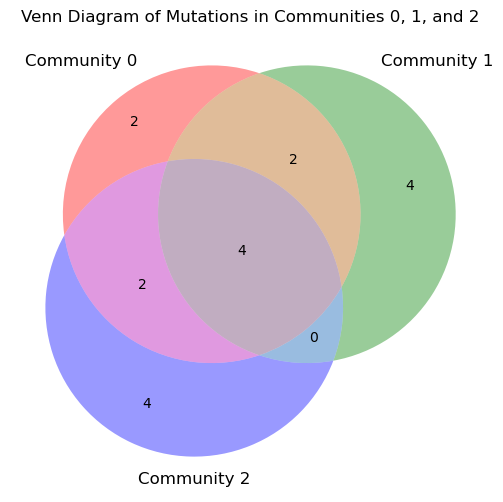

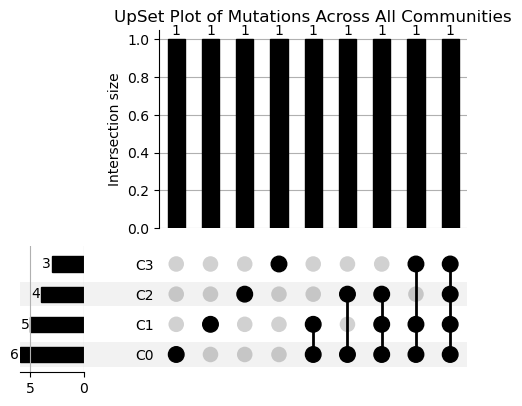

In [561]:
mutation_data = {}
for i in range(len(top_mutations)):
    mutation_data[i] = [i['hugoGeneSymbol'] for i in top_mutations[i]]

display(mutation_data)

# Create sets for communities 0, 1, 2
set0 = set(mutation_data[0])
set1 = set(mutation_data[1])
set2 = set(mutation_data[2])

# Plot Venn diagram for communities 0, 1, 2
plt.figure(figsize=(8, 6))
venn3([set0, set1, set2], set_labels=('Community 0', 'Community 1', 'Community 2'))
plt.title("Venn Diagram of Mutations in Communities 0, 1, and 2")
plt.show()

# Prepare data for UpSet plot for all four communities
all_genes = set.union(*[set(mutation_data[i]) for i in range(4)])
data = []

for gene in all_genes:
    presence = tuple(gene in mutation_data[i] for i in range(4))
    data.append(presence)

# Create a DataFrame for UpSet plot
df = pd.DataFrame(data, columns=['C0', 'C1', 'C2', 'C3'])
df['count'] = 1
df = df.groupby(['C0', 'C1', 'C2', 'C3']).count()

# Plot UpSet plot
upset = UpSet(df, subset_size='count', show_counts=True)
upset.plot()
plt.title("UpSet Plot of Mutations Across All Communities")
plt.show()


In [562]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
# for col in columns_to_analyze:
#     top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [563]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()

In [564]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
# numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

## Survival analysis

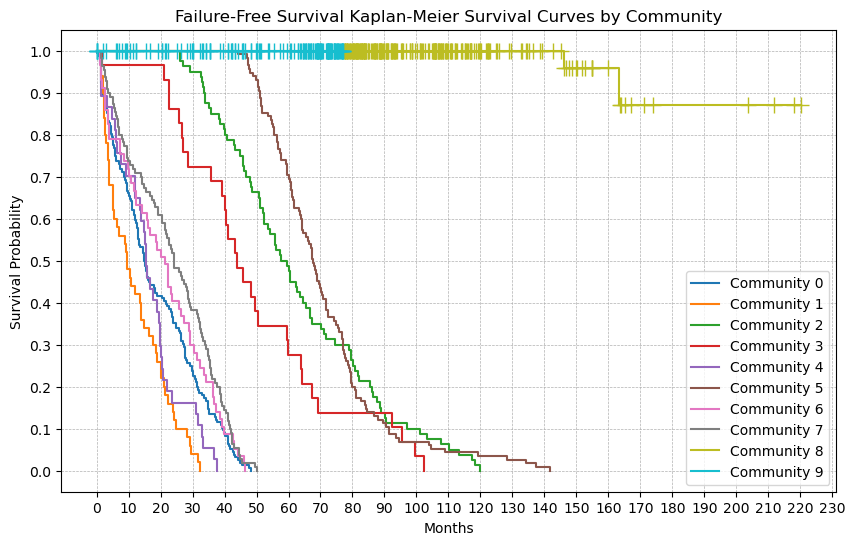

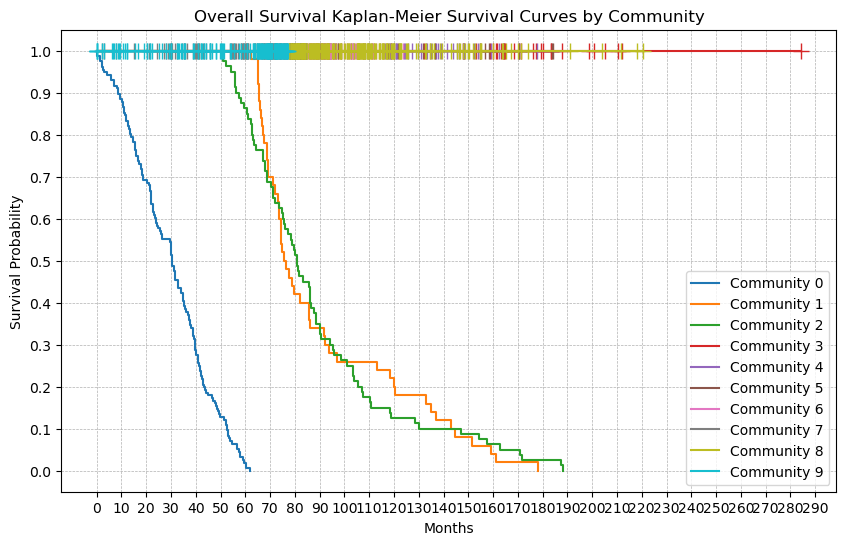

In [565]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')

    plt.figure(figsize=(10,6))
    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False, show_censors=True)
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    
    # Set ticks at every 10 units
    max_time = df[time_col].max()
    plt.xticks(np.arange(0, max_time + 10, 10))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if time_col == 'FFS_MONTHS':
        plt.savefig("../../figures/survival_curves.png", dpi = 300)
    else:
        plt.savefig("../../figures/os_survival_curves.png", dpi = 300)
    plt.show()

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

In [566]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

def survival_km_with_stats(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')
    print(df['communityId'].value_counts())

    median_survival_times = {}
    df_median_times = {}
    df_mean_times = {}

    # Define time points for restricted mean survival time
    time_points = [float('inf'), 3, 5, 10]
    mean_survival_times_by_t = {f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)': {} for t in time_points}

    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col])

        # Median survival time from Kaplan-Meier curve
        median_survival_times[name] = kmf.median_survival_time_

        # Mean survival time using area under the curve at different time points
        for t in time_points:
            label_t = f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)'
            new_t = t if t == float('inf') else t*12
            mean_survival_times_by_t[label_t][name] = restricted_mean_survival_time(kmf, t=new_t)

        # Median and mean directly from the DataFrame
        df_median_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].median()
        df_mean_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].mean()

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'KM Median Survival Time': median_survival_times,
        'DF Median Survival Time': df_median_times,
        'DF Mean Survival Time': df_mean_times
    })

    # Add mean survival times at different t values
    for label, values in mean_survival_times_by_t.items():
        summary_df[label] = pd.Series(values)

    return summary_df



summary_ffs = survival_km_with_stats(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
summary_os = survival_km_with_stats(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

print("FFS")
display(summary_ffs)
print("OS")
display(summary_os)


communityId
8    226
0    156
9    148
5    115
7    110
2     80
6     57
1     50
4     37
3     29
Name: count, dtype: int64
communityId
8    226
0    156
9    148
5    115
7    110
2     80
6     57
1     50
4     37
3     29
Name: count, dtype: int64
FFS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,14.86,15.025,18.415577,18.415577,17.650577,18.415577,18.415577
1,9.40,9.485,12.043200,12.043200,12.043200,12.043200,12.043200
2,59.51,58.505,63.004500,63.004500,35.344375,51.715125,63.004500
3,43.76,43.760,49.223103,49.223103,32.134483,43.210345,49.223103
4,15.32,15.320,16.179459,16.179459,16.116486,16.179459,16.179459
5,67.50,67.500,70.849391,70.849391,36.000000,57.970783,70.312783
6,21.37,21.370,20.877018,20.877018,19.923333,20.877018,20.877018
7,24.16,24.230,23.710000,23.710000,22.426818,23.710000,23.710000
8,inf,154.750,154.750000,inf,36.000000,60.000000,120.000000
9,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


OS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,30.28,30.360,29.899295,29.899295,25.825705,29.884167,29.899295
1,75.52,76.060,91.522800,91.522800,36.000000,60.000000,86.262200
2,80.97,80.875,88.955375,88.955375,36.000000,59.342500,83.968125
3,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
4,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
5,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
6,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
7,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
8,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
9,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


In [567]:
# Filter rows where FFS_EVENT is 1
filtered_df = merged_df[merged_df['FFS_STATUS_EVENT'] == 1]

# Find the row with the minimum FFS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['FFS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

# Find the row with the maximum FFS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['FFS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

     communityId  FFS_MONTHS
771            0        0.07
683            1        1.12
835            2       26.01
658            3        1.55
775            4        1.02
566            5       44.28
776            6        1.02
858            7        1.35
803            8      119.18
     communityId  FFS_MONTHS
231            0       48.13
325            1       32.42
682            2      119.74
29             3      102.25
118            4       37.77
707            5      141.70
19             6       59.93
210            7       50.00
934            8      220.30
714            9       77.03


In [568]:
# Filter rows where OS_EVENT is 1
filtered_df = merged_df[merged_df['OS_STATUS_EVENT'] == 1]

# Find the row with the minimum OS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['OS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

# Find the row with the maximum OS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['OS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

     communityId  OS_MONTHS
771            0       0.07
375            1      62.37
278            2      50.86
     communityId  OS_MONTHS
230            0      61.74
614            1     178.12
654            2     188.15
29             3     284.31
617            4     177.83
802            5     184.01
656            6     200.84
260            7      84.39
934            8     220.30
714            9      77.03


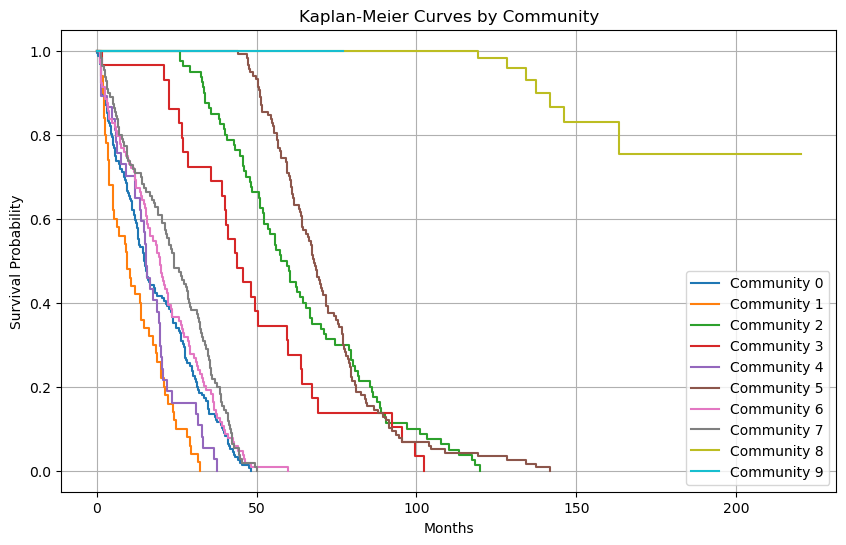

Log-Rank Test between Community 2 and 0: p = 5.620839536960058e-39
Log-Rank Test between Community 2 and 3: p = 0.024754373156605877
Log-Rank Test between Community 2 and 5: p = 0.14270452396380626
Log-Rank Test between Community 2 and 6: p = 1.439486020642594e-33
Log-Rank Test between Community 2 and 4: p = 3.881803882972484e-35
Log-Rank Test between Community 2 and 8: p = 7.609830277053095e-105
Log-Rank Test between Community 2 and 9: p = 1.4693116921120242e-21
Log-Rank Test between Community 2 and 7: p = 1.8754726353368245e-32
Log-Rank Test between Community 2 and 1: p = 4.050287786583371e-40
Log-Rank Test between Community 0 and 3: p = 3.669307402220035e-12
Log-Rank Test between Community 0 and 5: p = 3.7695959271220585e-67
Log-Rank Test between Community 0 and 6: p = 0.18790290930332115
Log-Rank Test between Community 0 and 4: p = 0.13142445319153515
Log-Rank Test between Community 0 and 8: p = 1.669005833173201e-119
Log-Rank Test between Community 0 and 9: p = 3.5349241139990995e

<lifelines.CoxPHFitter: fitted with 1062 total observations, 372 right-censored observations>
             duration col = 'FFS_MONTHS'
                event col = 'FFS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 690
   partial log-likelihood = -3496.87
         time fit was run = 2025-07-25 13:14:25 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1   0.68      1.98      0.17            0.36            1.01                1.43                2.74
communityId_2  -3.04      0.05      0.19           -3.41           -2.66                0.03                0.07
communityId_3  -2.53      0.08      0.24           -2.99           -2.06                0.05                0.13
communityId_4   0.34      1.40      0.18           -0.03            0.70                0.97                2.01
communityId_5  -3.28      0.04      0.18           -3.63           -2.92                0.03                0.05
communityId_6  -0.21      0.81      0.13           -0.46            0.04                0.63                1.04
communityId_7  -0.34      0.71      0.12           -0.58           -0.09                0.56                0.91
communityId_8  -8.15      0.00      0.49           -9.11           -7.20                0.00                0.00
communityId_9 -20.68      0.00    717.72        -1427.39         1386.02                0.00                 inf

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00   4.11 <0.005     14.65
communityId_2    0.00 -15.87 <0.005    186.01
communityId_3    0.00 -10.64 <0.005     85.46
communityId_4    0.00   1.82   0.07      3.85
communityId_5    0.00 -17.95 <0.005    236.96
communityId_6    0.00  -1.63   0.10      3.28
communityId_7    0.00  -2.72   0.01      7.25
communityId_8    0.00 -16.75 <0.005    206.80
communityId_9    0.00  -0.03   0.98      0.03
---
Concordance = 0.87
Partial AIC = 7011.75
log-likelihood ratio test = 1787.07 on 9 df
-log2(p) of ll-ratio test = inf

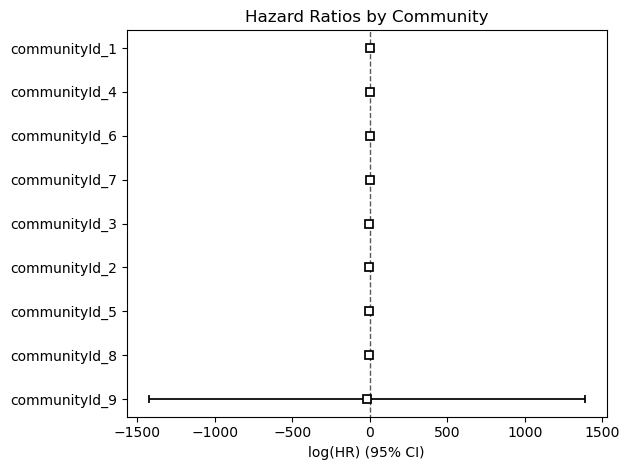

In [569]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['FFS_STATUS_EVENT'] = mod_df['FFS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['FFS_MONTHS'], group['FFS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['FFS_MONTHS'], group_b['FFS_MONTHS'],
                          event_observed_A=group_a['FFS_STATUS_EVENT'],
                          event_observed_B=group_b['FFS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='FFS_MONTHS', event_col='FFS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

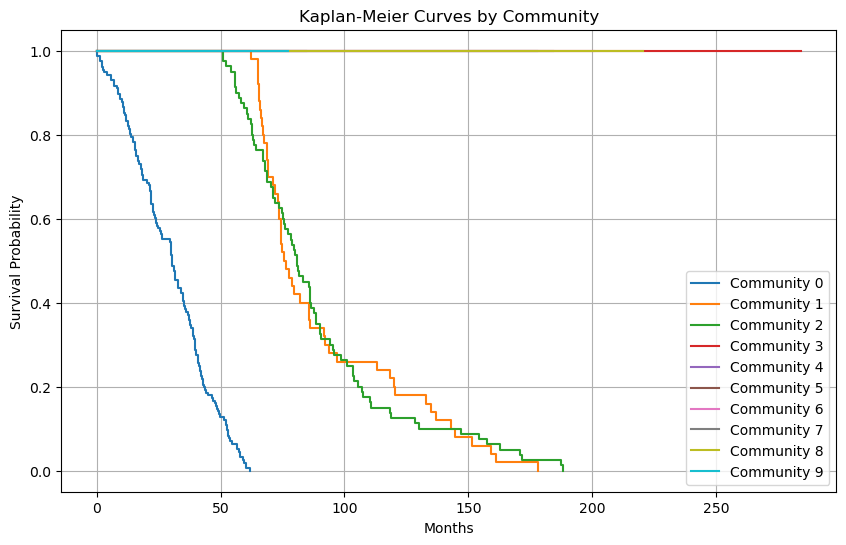

Log-Rank Test between Community 2 and 0: p = 2.510351350550825e-46
Log-Rank Test between Community 2 and 3: p = 4.415496864081551e-19
Log-Rank Test between Community 2 and 5: p = 1.3814664442772524e-28
Log-Rank Test between Community 2 and 6: p = 1.72880327190916e-39
Log-Rank Test between Community 2 and 4: p = 3.1939645674914436e-18
Log-Rank Test between Community 2 and 8: p = 1.1045728967407809e-76
Log-Rank Test between Community 2 and 9: p = 6.197558187184306e-08
Log-Rank Test between Community 2 and 7: p = 9.73791993048405e-09
Log-Rank Test between Community 2 and 1: p = 0.9977442115444316
Log-Rank Test between Community 0 and 3: p = 7.531552176471825e-23
Log-Rank Test between Community 0 and 5: p = 1.6373006163469246e-67
Log-Rank Test between Community 0 and 6: p = 2.2894856579970196e-61
Log-Rank Test between Community 0 and 4: p = 1.9385843991664533e-27
Log-Rank Test between Community 0 and 8: p = 1.8467648453084894e-119
Log-Rank Test between Community 0 and 9: p = 1.452924728645

<lifelines.CoxPHFitter: fitted with 1062 total observations, 776 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 286
   partial log-likelihood = -1171.51
         time fit was run = 2025-07-25 13:14:26 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1  -3.99      0.02      0.34           -4.65           -3.32                0.01                0.04
communityId_2  -3.99      0.02      0.33           -4.63           -3.34                0.01                0.04
communityId_3 -26.23      0.00   6580.35       -12923.48        12871.02                0.00                 inf
communityId_4 -26.07      0.00   6944.43       -13636.91        13584.76                0.00                 inf
communityId_5 -25.75      0.00   4715.93        -9268.80         9217.30                0.00                 inf
communityId_6 -25.99      0.00   4416.17        -8681.52         8629.55                0.00                 inf
communityId_7 -25.06      0.00   6456.20       -12678.99        12628.86                0.00                 inf
communityId_8 -25.92      0.00   3076.15        -6055.06         6003.21                0.00                 inf
communityId_9 -24.87      0.00   6281.30       -12336.00        12286.26                0.00                 inf

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00 -11.77 <0.005    103.86
communityId_2    0.00 -12.14 <0.005    110.31
communityId_3    0.00  -0.00   1.00      0.00
communityId_4    0.00  -0.00   1.00      0.00
communityId_5    0.00  -0.01   1.00      0.01
communityId_6    0.00  -0.01   1.00      0.01
communityId_7    0.00  -0.00   1.00      0.00
communityId_8    0.00  -0.01   0.99      0.01
communityId_9    0.00  -0.00   1.00      0.00
---
Concordance = 0.95
Partial AIC = 2361.01
log-likelihood ratio test = 1341.98 on 9 df
-log2(p) of ll-ratio test = 938.70

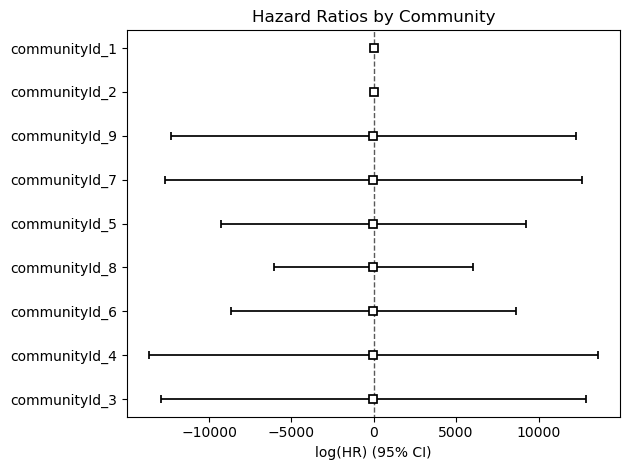

In [570]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['OS_STATUS_EVENT'] = mod_df['OS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['OS_MONTHS'], group['OS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['OS_MONTHS'], group_b['OS_MONTHS'],
                          event_observed_A=group_a['OS_STATUS_EVENT'],
                          event_observed_B=group_b['OS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='OS_MONTHS', event_col='OS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

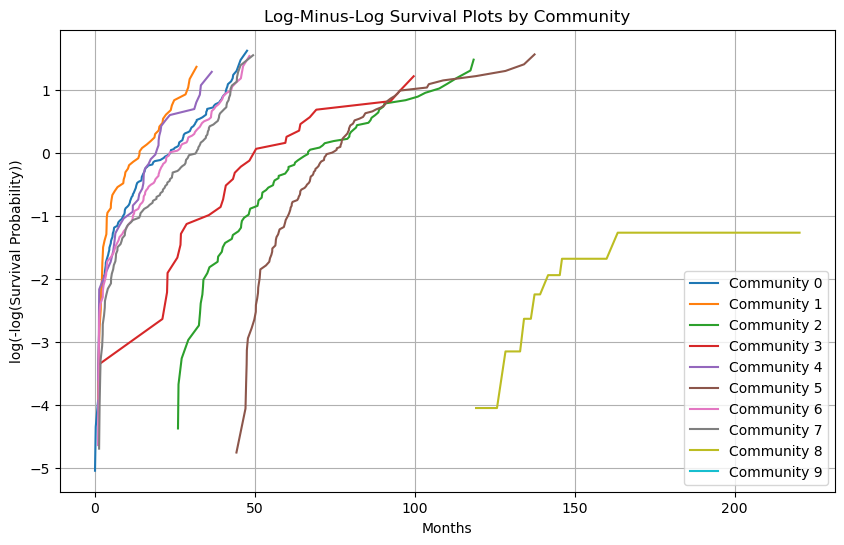

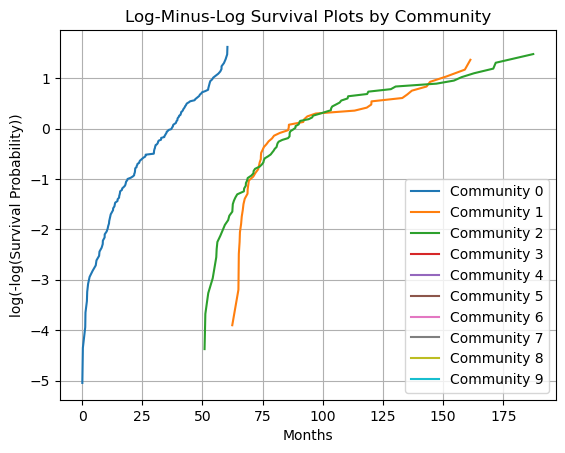

In [571]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Log-minus-log plots
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for label in ['FFS', 'OS']:
    for name, group in mod_df.groupby('communityId'):
        kmf.fit(group[f'{label}_MONTHS'], group[f'{label}_STATUS_EVENT'], label=f"Community {name}")
        survival_prob = kmf.survival_function_[f"Community {name}"]
        log_minus_log = np.log(-np.log(survival_prob))
        plt.plot(survival_prob.index, log_minus_log, label=f"Community {name}")

    plt.title("Log-Minus-Log Survival Plots by Community")
    plt.xlabel("Months")
    plt.ylabel("log(-log(Survival Probability))")
    plt.legend()
    plt.grid(True)
    plt.show()


## Visualisation

In [572]:
base_path = "../../figures/chapter4/"
os.makedirs(base_path, exist_ok=True)

In [573]:
def get_parent_comm(subcommunity_id):
    if subcommunity_id in [0,1,2]:
        return 0
    elif subcommunity_id in [3,4]:
        return 1
    elif subcommunity_id in [5,6, 7]:
        return 2
    elif subcommunity_id in [8,9]:
        return 3
    else:
        return -1
    
parent_community_names = {
    0: "Early Failure with Death",
    1: "Early Failure with Survival",
    2: "Intermediate Failure with Survival",
    3: "Sustained Survival"
}

In [574]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
from collections import Counter

def plot_violin_numeric(df, feature, comm1, comm2, ax, show_median=True, color_palette='Set2'):
    data = df[df['communityId'].isin([comm1, comm2])]
    sns.violinplot(data=data, x='communityId', y=feature, ax=ax, palette=color_palette, inner='box')
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Sub-community ID")
    ax.set_ylabel(feature)
    # Annotate median
    for i, cid in enumerate([comm1, comm2]):
        median = data[data['communityId'] == cid][feature].median()
        # ax.axhline(median, color=sns.color_palette(color_palette)[i], linestyle='--', linewidth=1)
        ax.text(i, median, f"Median: {median:.2f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')

def plot_box_numeric(df, feature, comm1, comm2, ax, show_median=True, color_palette='Set2'):
    data = df[df['communityId'].isin([comm1, comm2])]
    sns.boxplot(data=data, x='communityId', y=feature, ax=ax, palette=color_palette)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Sub-community ID")
    ax.set_ylabel(feature)
    # Annotate median
    for i, cid in enumerate([comm1, comm2]):
        median = data[data['communityId'] == cid][feature].median()
        ax.text(i, median, f"Median: {median:.2f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')

In [575]:
def round_percentages_to_100(row):
    """Given a list/array of values, return a list of rounded percentages (1 decimal) summing to 100."""
    total = np.sum(row)
    if total == 0:
        return [0.0] * len(row)
    raw = [v / total * 100 for v in row]
    rounded = [np.floor(x * 10) / 10 for x in raw]
    diff = round(100 - sum(rounded), 1)
    # Distribute the remaining difference to the largest remainders
    remainders = [x - np.floor(x * 10) / 10 for x in raw]
    idxs = np.argsort(remainders)[::-1]
    i = 0
    while abs(diff) > 1e-6:
        rounded[idxs[i % len(rounded)]] += 0.1
        diff = round(100 - sum(rounded), 1)
        i += 1
    return [round(x, 1) for x in rounded]

In [576]:
cll_epitype_colors = {
    'm-CLL': '#66c2a5',
    'i-CLL': '#8da0cb', 
    'n-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

tumor_colors = {
    'M-CLL': '#66c2a5',
    'U-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

ighv_colors = {
    'mutated': '#66c2a5',
    'unmutated': '#fc8d62',
    'unknown': '#7f7f7f',
}


legend_mapping = {
    'CLL_EPITYPE': cll_epitype_colors,
    'TUMOR_MOLECULAR_SUBTYPE': tumor_colors,
    'IGHV_MUTATION_STATUS': ighv_colors
}

def plot_stacked_bar_categorical(
    df, feature, comm1, comm2, ax,
    y_axis='count', annotation='percent',
):
    """
    y_axis: 'count' or 'percent' (controls y-axis)
    annotation: 'count' or 'percent' (controls annotation on bars)
    category_map: dict {category_value: color_hex, ...} for legend order and color
    """
    data = df[df['communityId'].isin([comm1, comm2])]
    ct = pd.crosstab(data['communityId'], data[feature])

    # Order columns and set colors if map provided
    category_map = legend_mapping.get(feature, None)
    if category_map:
        ordered_cats = list(category_map.keys())
        ct = ct.reindex(columns=ordered_cats, fill_value=0)
        colors = [category_map[k] for k in ordered_cats]
    else:
        colors = None

    # Compute percent table for annotation if needed
    ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

    # Choose y-axis
    if y_axis == 'percent':
        plot_df = ct_percent
        ylabel = "Percentage"
    else:
        plot_df = ct
        ylabel = "Count"

    # Plot
    plot_df.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Sub-community ID")
    ax.set_ylabel(ylabel)
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    if category_map:
        # Order legend as in map
        ax.legend(handles, ordered_cats, bbox_to_anchor=(1.05, 1), loc='upper left')
        # title=feature, 
    else:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # title=feature, 

     # Annotate (robust: loop over bars and categories)
    bar_categories = list(plot_df.columns)
    bar_positions = np.arange(len(plot_df.index))  # x positions for bars (communities)
    for bar_idx, comm in enumerate(plot_df.index):
        y_bottom = 0
        # For percent annotation, get rounded percentages that sum to 100
        if annotation == 'percent':
            row_counts = ct.iloc[bar_idx].values
            rounded_percents = round_percentages_to_100(row_counts)
        for cat_idx, cat in enumerate(bar_categories):
            value = plot_df.iloc[bar_idx][cat]
            if value == 0:
                continue
            count = ct.iloc[bar_idx][cat] if cat in ct.columns else 0
            percent = ct_percent.iloc[bar_idx][cat] if cat in ct_percent.columns else 0
            if annotation == 'percent':
                text = f"{rounded_percents[cat_idx]}%"
            else:
                text = f"{int(count)}"
            y = y_bottom + value / 2
            ax.annotate(
                text,
                (bar_positions[bar_idx], y),
                ha='center', va='center', fontsize=8, color='black'
            )
            y_bottom += value
            

In [577]:
def compare_communities(
    df, comm1, comm2, 
    numeric_features=None, 
    categorical_features=None, 
    y_axis_categorical='count',
    annotation_categorical='percent',
    violin_palette='Set2',
    figsize=(12, 8)
):
    # Count number of plots
    n_numeric = len(numeric_features) if numeric_features else 0
    n_categorical = len(categorical_features) if categorical_features else 0
    n_plots = n_numeric + n_categorical
    ncols = int(np.ceil(np.sqrt(n_plots)))
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if n_plots > 1 else [axes]
    idx = 0

    # Numeric features
    if numeric_features:
        for feature in numeric_features:
            if feature == 'MUTATION_COUNT':
                plot_box_numeric(df, feature, comm1, comm2, axes[idx], color_palette=violin_palette)
            else:
                plot_violin_numeric(df, feature, comm1, comm2, axes[idx], color_palette=violin_palette)
            idx += 1

    # Categorical features
    if categorical_features:
        for feature in categorical_features:
            plot_stacked_bar_categorical(df, feature, comm1, comm2, axes[idx], y_axis_categorical, annotation_categorical)
            idx += 1

    # Hide unused axes
    for j in range(idx, len(axes)):
        axes[j].axis('off')

    # title for the entire figure
    fig.suptitle(f"Comparison between Sub-communities of \"{parent_community_names[get_parent_comm(comm1)]}\" (CommID {get_parent_comm(comm1)})\nSub-community {comm1} vs Sub-community {comm2}", fontsize=16, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    fig.savefig(f"{base_path}community_comparison_subcomm_{comm1}_{comm2}.png", dpi=300)
    plt.show()

In [578]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd

def plot_venn_feature_figure(
    top_dict, comm1, comm2, label, 
    min_pct=0, 
    top_selected=10,
    left_name=None, right_name=None, 
    save_prefix="venn"
):
    """
    Creates and saves a solo Venn diagram for a feature (e.g., mutations or treatments).
    - top_dict: {communityId: [{label: value, 'Percentage': pct}, ...]}
    - comm1, comm2: community ids (left, right)
    - label: key in dict (e.g., 'hugoGeneSymbol' or 'TREATMENT_AFTER_SAMPLING')
    - min_pct: minimum percentage to include
    - left_name, right_name: custom names for communities (optional)
    - save_prefix: prefix for filename
    """
    # Filter out NaN labels
    set1 = {d[label]: d['Percentage'] for d in top_dict.get(comm1, []) if d['Percentage'] >= min_pct and not pd.isna(d[label])}
    set2 = {d[label]: d['Percentage'] for d in top_dict.get(comm2, []) if d['Percentage'] >= min_pct and not pd.isna(d[label])}
    print(set1, set2)
    
    keys1, keys2 = set(set1.keys()), set(set2.keys())

    fig, ax = plt.subplots(figsize=(10, 8))
    venn = venn2([keys1, keys2], set_labels=(
        left_name or f"Sub-community {comm1}",
        right_name or f"Sub-community {comm2}"
    ), ax=ax)
    from matplotlib_venn import venn2_circles
    venn2_circles(subsets=(keys1, keys2), ax=ax)

    # Annotate unique and common, skip NaN
    for keys, venn_id in zip([keys1-keys2, keys2-keys1, keys1&keys2], ['10', '01', '11']):
        # Remove NaN keys
        keys = [k for k in keys if not pd.isna(k)]
        if venn_id == '10':
            # Sort by set1 percentage descending
            keys_sorted = sorted(keys, key=lambda k: -set1[k])
        elif venn_id == '01':
            # Sort by set2 percentage descending
            keys_sorted = sorted(keys, key=lambda k: -set2[k])
        else:
            # Sort by average percentage descending
            keys_sorted = sorted(keys, key=lambda k: -((set1.get(k, 0) + set2.get(k, 0))/2))

        if venn.get_label_by_id(venn_id):
            if venn_id == '10':
                text = "\n".join([f"{k}\n({set1[k]:.1f}%)" for k in keys_sorted])
            elif venn_id == '01':
                text = "\n".join([f"{k}\n({set2[k]:.1f}%)" for k in keys_sorted])
            else:
                text = "\n".join([
                    f"{k}\n({set1[k]:.1f}% vs {set2[k]:.1f}%)"
                    for k in keys_sorted
                ])
            venn.get_label_by_id(venn_id).set_text(text if text else "")

    title_field = ""
    if label == 'hugoGeneSymbol':
        title_field = f"Venn Diagram: Mutations (hugoGeneSymbol) (Top {top_selected}, % of patients)"
    else:
        title_field = f"Venn Diagram: {label} (Top {top_selected}, % of patients)"
    title_field += f"\nSub-communities of \"{parent_community_names[get_parent_comm(comm1)]}\" (CommID {get_parent_comm(comm1)})\nSub-community {comm1} vs Sub-community {comm2}"
    ax.set_title(title_field, fontsize=16)
    
    
    plt.tight_layout()
    fname = f"{base_path}{save_prefix}_{label}_subcomm{comm1}_subcomm{comm2}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved Venn diagram to {fname}")

In [579]:
def plot_side_by_side_venn(
    mutation_dict, treatment_dict, comm1, comm2,
    mutation_label='hugoGeneSymbol',
    treatment_label='TREATMENT_AFTER_SAMPLING',
    min_pct=0, top_selected=10,
    left_name=None, right_name=None,
    save_prefix="venn_subcomm"
):
    """
    Plots mutation and treatment Venn diagrams side by side for two sub-communities.
    """
    import matplotlib.pyplot as plt
    from matplotlib_venn import venn2, venn2_circles
    import pandas as pd

    # Prepare sets for mutations
    set1_mut = {d[mutation_label]: d['Percentage'] for d in mutation_dict.get(comm1, []) if d['Percentage'] >= min_pct and not pd.isna(d[mutation_label])}
    set2_mut = {d[mutation_label]: d['Percentage'] for d in mutation_dict.get(comm2, []) if d['Percentage'] >= min_pct and not pd.isna(d[mutation_label])}
    keys1_mut, keys2_mut = set(set1_mut.keys()), set(set2_mut.keys())

    # Prepare sets for treatments
    set1_trt = {d[treatment_label]: d['Percentage'] for d in treatment_dict.get(comm1, []) if d['Percentage'] >= min_pct and not pd.isna(d[treatment_label])}
    set2_trt = {d[treatment_label]: d['Percentage'] for d in treatment_dict.get(comm2, []) if d['Percentage'] >= min_pct and not pd.isna(d[treatment_label])}
    keys1_trt, keys2_trt = set(set1_trt.keys()), set(set2_trt.keys())

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # --- Mutations Venn ---
    venn_mut = venn2([keys1_mut, keys2_mut], set_labels=(
        left_name or f"Sub-community {comm1}",
        right_name or f"Sub-community {comm2}"
    ), ax=axes[0])
    venn2_circles([keys1_mut, keys2_mut], ax=axes[0])

    for keys, venn_id in zip([keys1_mut-keys2_mut, keys2_mut-keys1_mut, keys1_mut&keys2_mut], ['10', '01', '11']):
        keys = [k for k in keys if not pd.isna(k)]
        if venn_id == '10':
            keys_sorted = sorted(keys, key=lambda k: -set1_mut[k])
        elif venn_id == '01':
            keys_sorted = sorted(keys, key=lambda k: -set2_mut[k])
        else:
            keys_sorted = sorted(keys, key=lambda k: -((set1_mut.get(k, 0) + set2_mut.get(k, 0))/2))
        if venn_mut.get_label_by_id(venn_id):
            if venn_id == '10':
                text = "\n".join([f"{k}\n({set1_mut[k]:.1f}%)" for k in keys_sorted])
            elif venn_id == '01':
                text = "\n".join([f"{k}\n({set2_mut[k]:.1f}%)" for k in keys_sorted])
            else:
                text = "\n".join([
                    f"{k}\n({set1_mut[k]:.1f}% vs {set2_mut[k]:.1f}%)"
                    for k in keys_sorted
                ])
            venn_mut.get_label_by_id(venn_id).set_text(text if text else "")

    axes[0].set_title(f"Mutations (Top {top_selected}, % of patients)\nSub-community {comm1} vs {comm2}", fontsize=14)

    # --- Treatments Venn ---
    venn_trt = venn2([keys1_trt, keys2_trt], set_labels=(
        left_name or f"Sub-community {comm1}",
        right_name or f"Sub-community {comm2}"
    ), ax=axes[1])
    venn2_circles([keys1_trt, keys2_trt], ax=axes[1])

    for keys, venn_id in zip([keys1_trt-keys2_trt, keys2_trt-keys1_trt, keys1_trt&keys2_trt], ['10', '01', '11']):
        keys = [k for k in keys if not pd.isna(k)]
        if venn_id == '10':
            keys_sorted = sorted(keys, key=lambda k: -set1_trt[k])
        elif venn_id == '01':
            keys_sorted = sorted(keys, key=lambda k: -set2_trt[k])
        else:
            keys_sorted = sorted(keys, key=lambda k: -((set1_trt.get(k, 0) + set2_trt.get(k, 0))/2))
        if venn_trt.get_label_by_id(venn_id):
            if venn_id == '10':
                text = "\n".join([f"{k}\n({set1_trt[k]:.1f}%)" for k in keys_sorted])
            elif venn_id == '01':
                text = "\n".join([f"{k}\n({set2_trt[k]:.1f}%)" for k in keys_sorted])
            else:
                text = "\n".join([
                    f"{k}\n({set1_trt[k]:.1f}% vs {set2_trt[k]:.1f}%)"
                    for k in keys_sorted
                ])
            venn_trt.get_label_by_id(venn_id).set_text(text if text else "")

    axes[1].set_title(f"Treatments (Top {top_selected}, % of patients)\nSub-community {comm1} vs {comm2}", fontsize=14)

    title_field = f"\nSub-communities of \"{parent_community_names[get_parent_comm(comm1)]}\" (CommID {get_parent_comm(comm1)})\nSub-community {comm1} vs Sub-community {comm2}"
    plt.suptitle(title_field, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    fname = f"{base_path}{save_prefix}_subcomm{comm1}_subcomm{comm2}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved side-by-side Venn diagram to {fname}")

## Calling visual functions

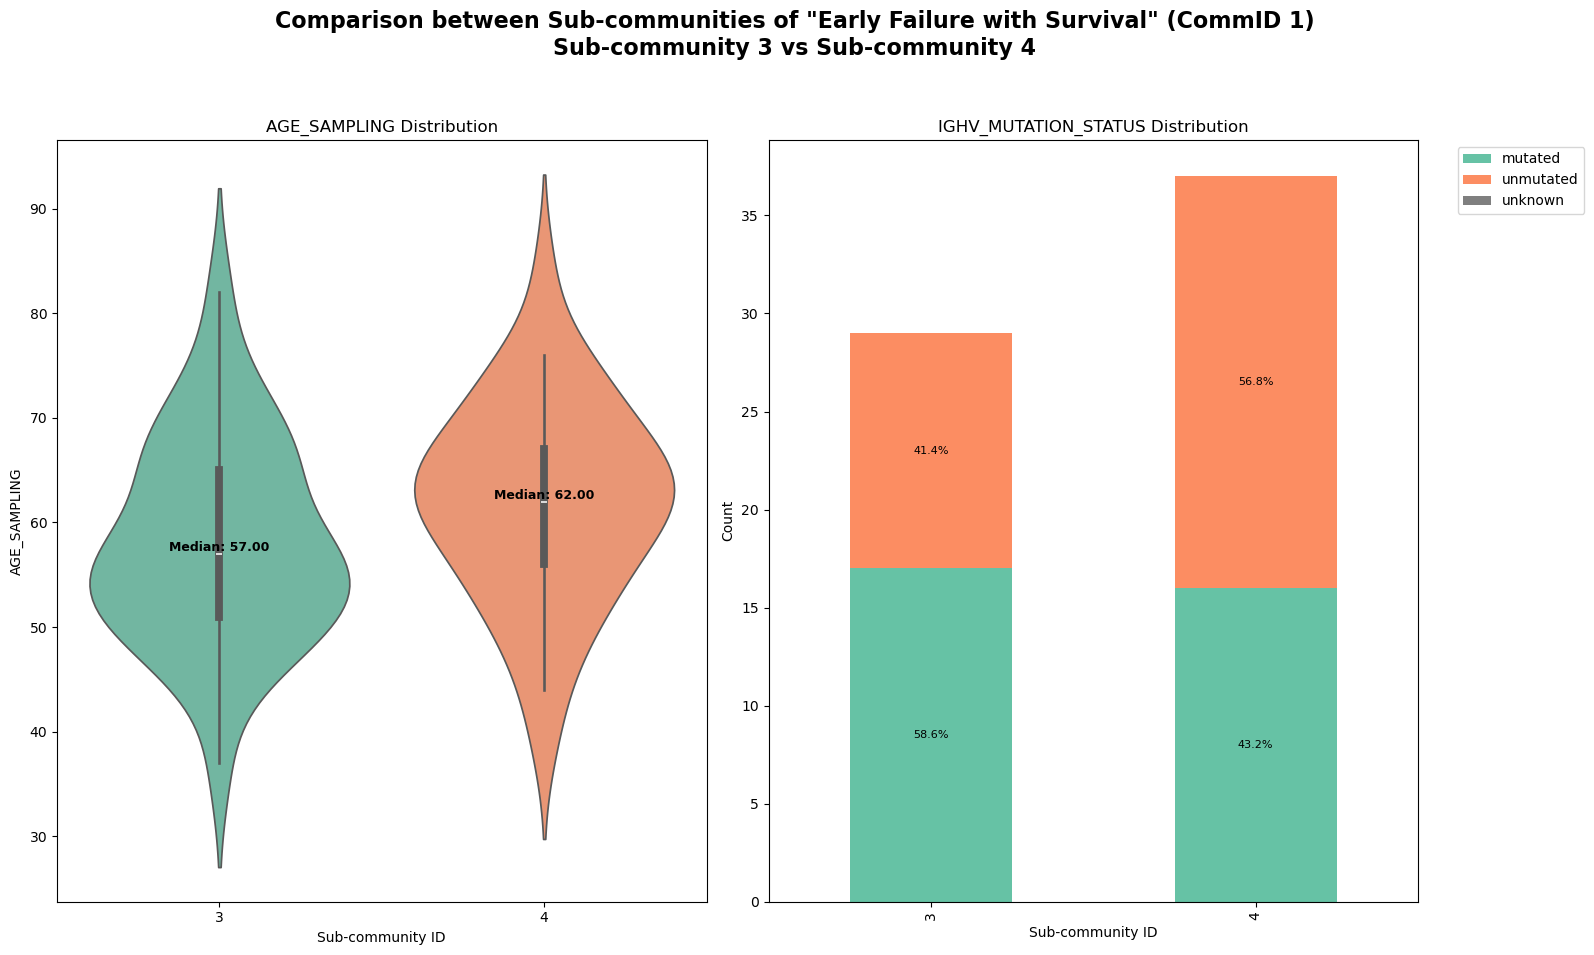

In [580]:
numeric_features = ['AGE_SAMPLING', 'MUTATION_COUNT']
categorical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']

compare_communities(
    merged_df, 
    comm1=3, comm2=4,
    numeric_features=['AGE_SAMPLING'],
    categorical_features=['IGHV_MUTATION_STATUS'],
    figsize=(16, 10),
)

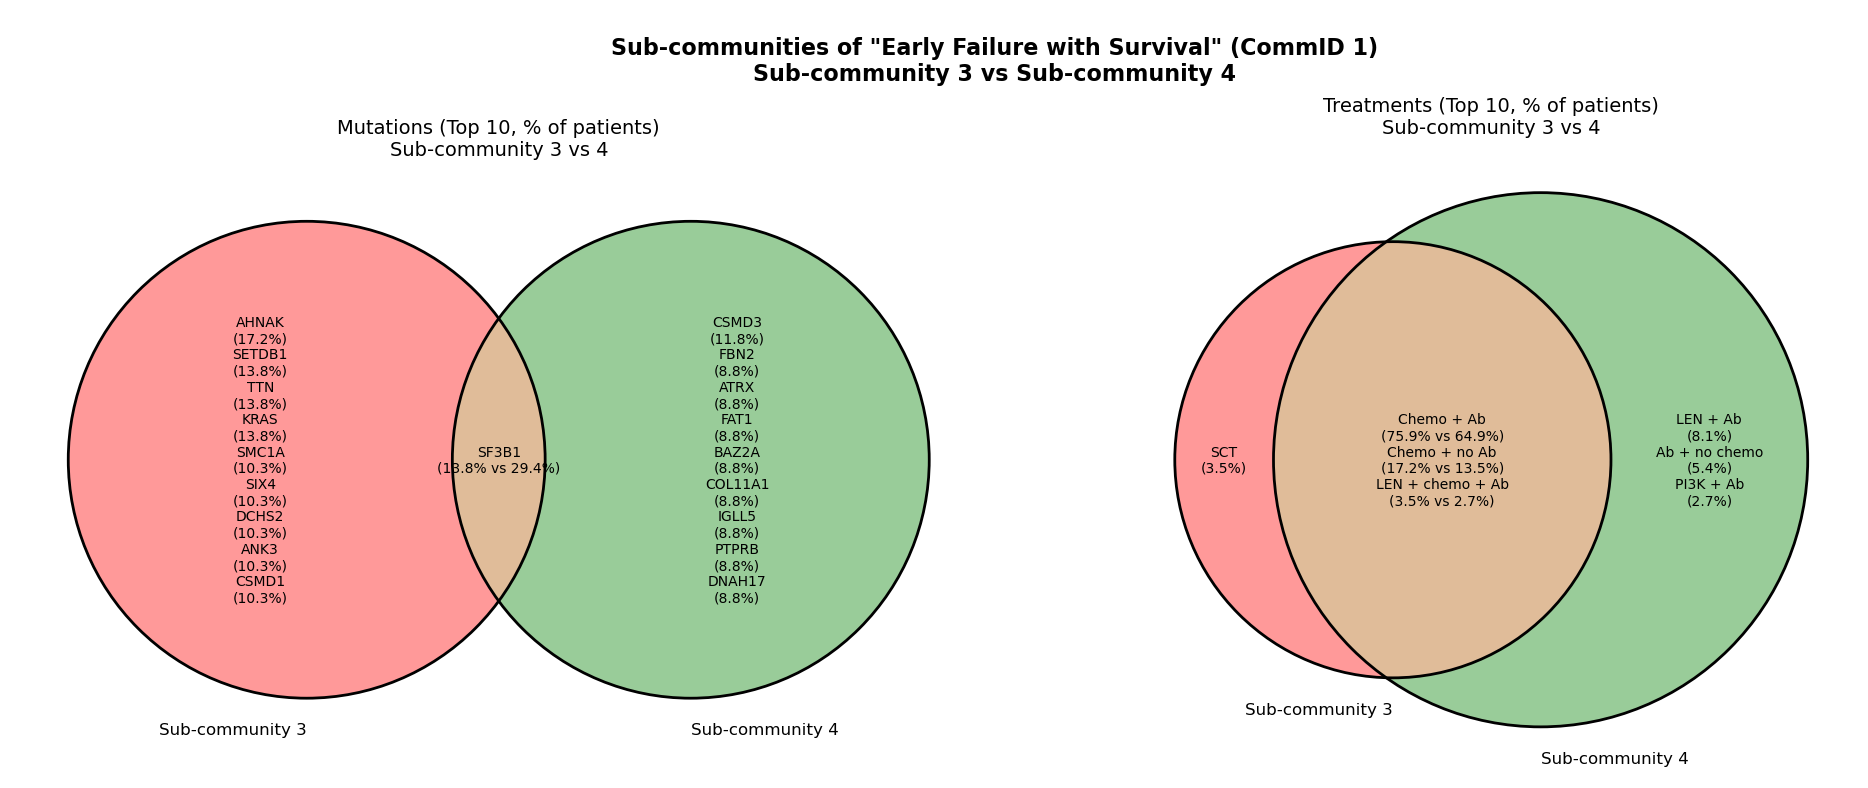

Saved side-by-side Venn diagram to ../../figures/chapter4/venn_subcomm_subcomm3_subcomm4.png


In [581]:
# plot_venn_feature_figure(top_mutations, 3, 4, 'hugoGeneSymbol', min_pct=0, save_prefix="venn_mutations")
# plot_venn_feature_figure(treatment_data, 3, 4, 'TREATMENT_AFTER_SAMPLING', min_pct=0, save_prefix="venn_treatment")
plot_side_by_side_venn(top_mutations, treatment_data, 3, 4, top_selected=10)

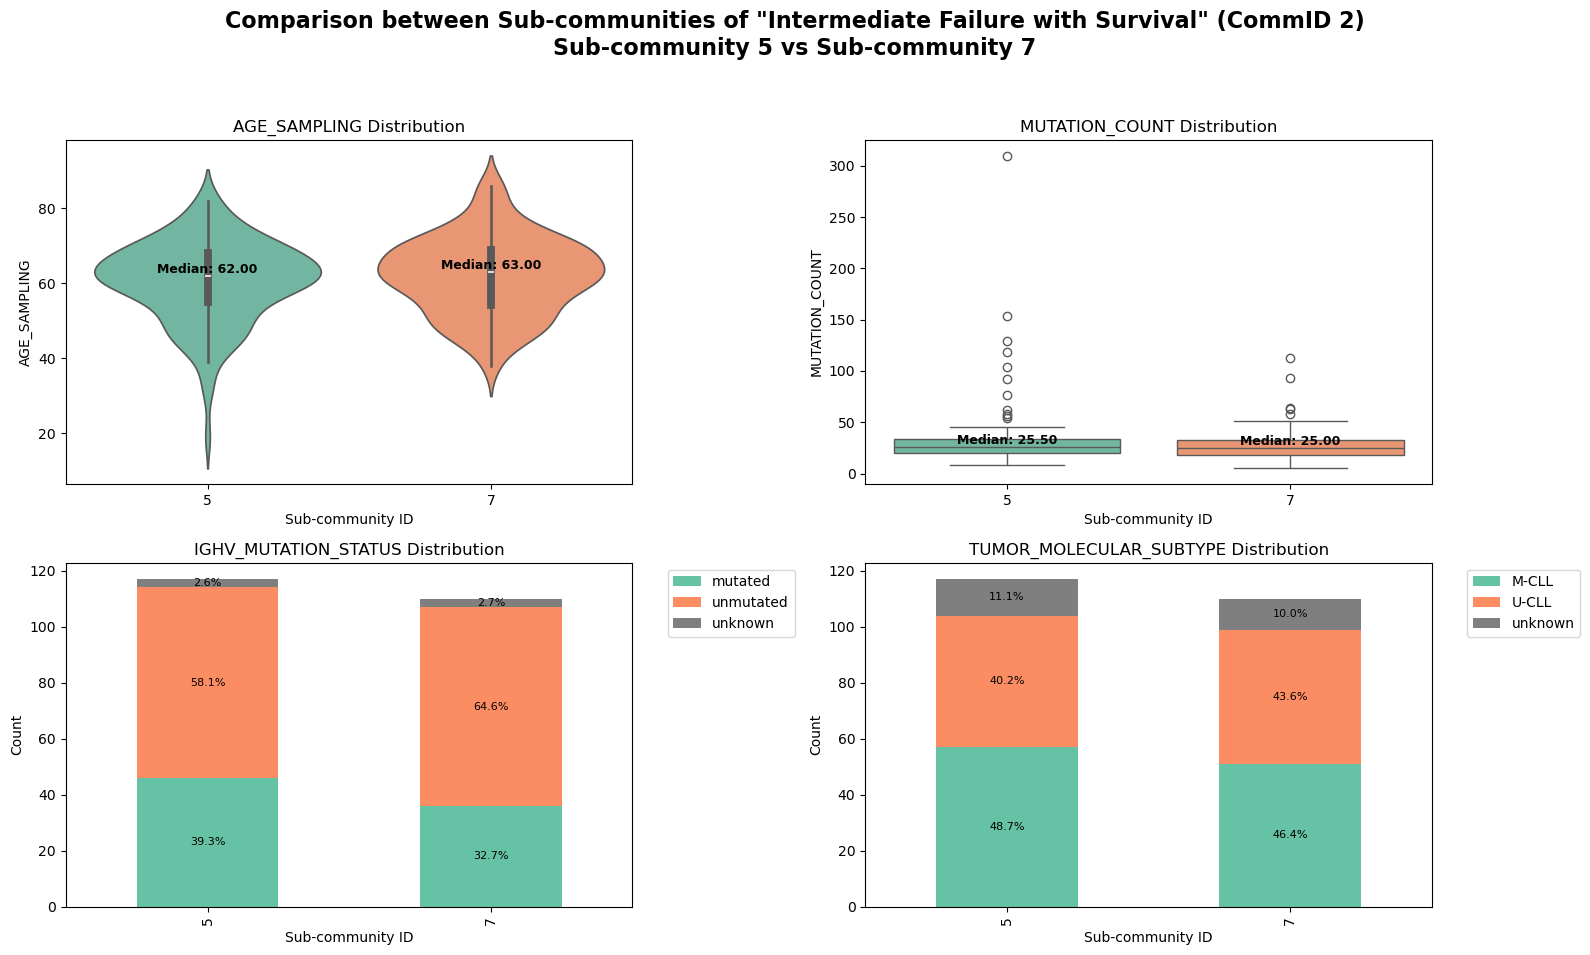

In [582]:
numeric_features = ['AGE_SAMPLING', 'MUTATION_COUNT']
categorical_features = ['IGHV_MUTATION_STATUS', 'TUMOR_MOLECULAR_SUBTYPE']

compare_communities(
    merged_df, 
    comm1=5, comm2=7,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    figsize=(16, 10),
)

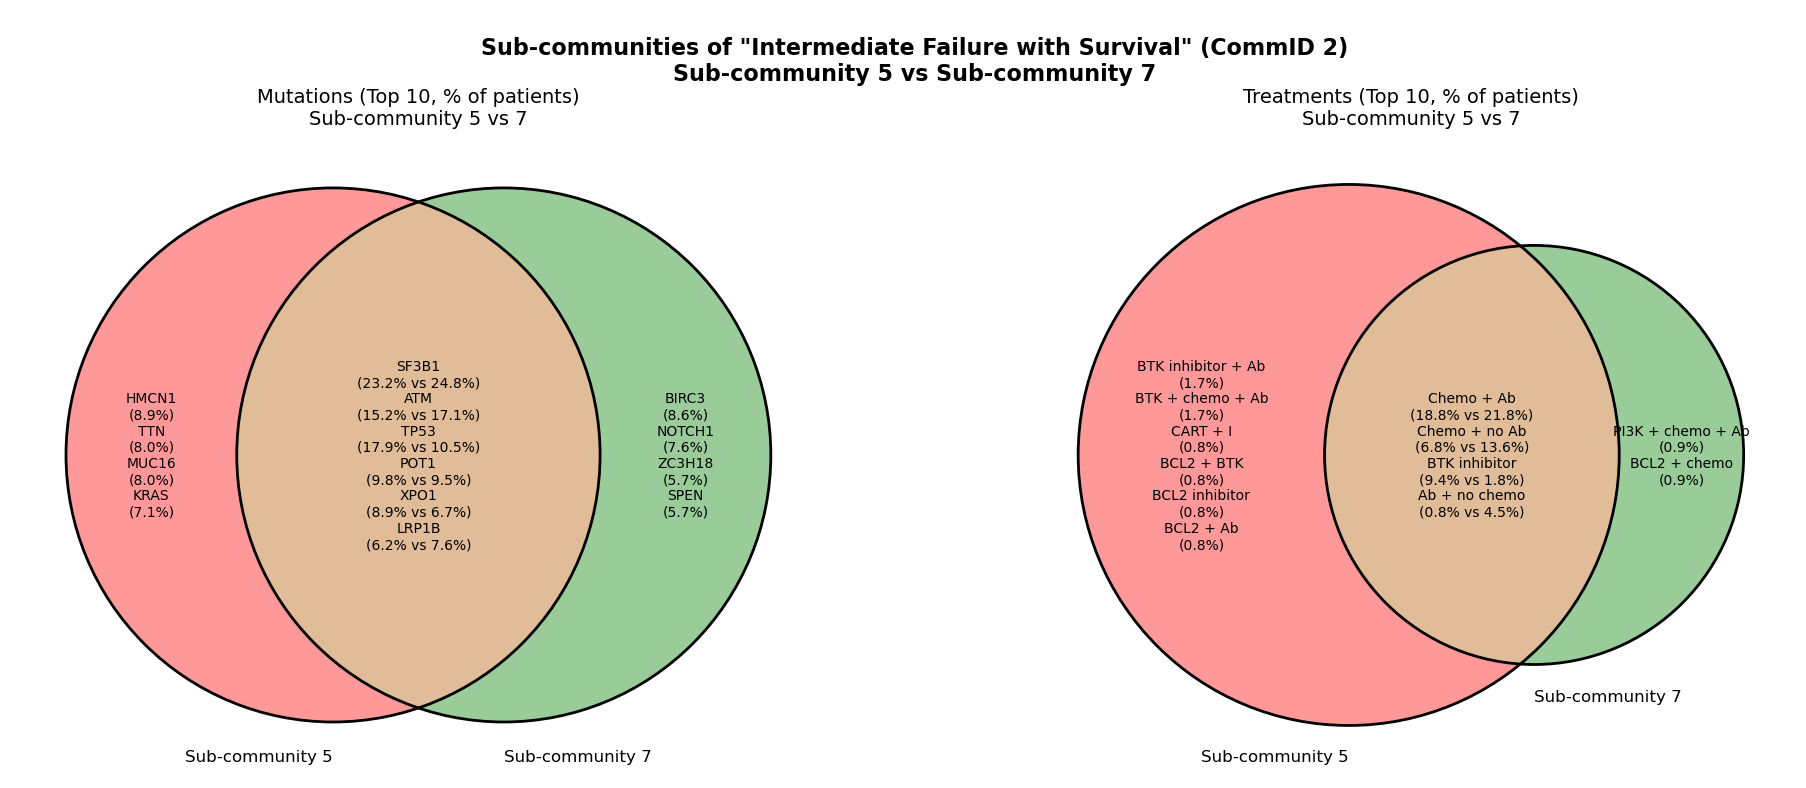

Saved side-by-side Venn diagram to ../../figures/chapter4/venn_subcomm_subcomm5_subcomm7.png


In [583]:
plot_side_by_side_venn(top_mutations, treatment_data, 5, 7, top_selected=10)